<a href="https://colab.research.google.com/github/grese/scad-tot/blob/master/alarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Awareness Notebook

---



In [0]:
%tensorflow_version 2.x
%load_ext tensorboard

import math, os, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from IPython.display import display, HTML
from sklearn import metrics
from sklearn.model_selection import train_test_split

TensorFlow 2.x selected.



## Setup
Basic setup and simple helper functions

In [0]:
tensorboard_logs = './logs'
pd.options.display.float_format = '{:.2f}'.format

def print_html(string, tag='span', color=None, size=None):
    size = f'font-size:{size};' if size else ''
    color = f'color:{color};' if color else ''
    display(HTML(f'<{tag} style="{color}{size}">{string}</{tag}>'))

def print_heading(string, color=None):
    print_html(string, tag='h3', color=color)

def print_message(string, color=None):
    print_html(string, color=color)

def download_csv_from_gdrive(gdrive_id, output_file):
    # Authenticate google drive
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Download csv from GDrive...
    print_message(f'Downloading {gdrive_id} from GDrive....')
    dataset = drive.CreateFile({'id': gdrive_id})
    dataset.GetContentFile(output_file)
    print_message(f'Downloaded {gdrive_id}.\nSaved as {output_file}')

def download_and_unzip(src_url, out_dir='./', zip_file='dl.zip', remove_zip=True):
    print_message(f'Downloading {src_url} to {zip_file}')
    !wget $src_url -O $zip_file -q --show-progress
    print_message(f'Download complete. Unzipping {zip_file}')
    z = zipfile.ZipFile(zip_file, 'r')
    z.extractall(out_dir)
    print_message(f'Unzipped to {out_dir}. Cleaning up...')
    z.close()
    if remove_zip: os.remove(zip_file)

## Install Marabou
Download, unzip, and setup marabou.

In [0]:
marabou_path = os.path.abspath('./marabou')
marabou_bin = f'{marabou_path}/marabou.elf'
marabou_url = 'https://aisafety.stanford.edu/marabou/marabou-1.0-x86_64-linux.zip'

# downloads and unzips the marabou binary...
def install_marabou():
    print_message('Installing marabou...')
    download_and_unzip(marabou_url, out_dir=marabou_path, zip_file='marabou.zip', remove_zip=True)
    print_message('Marabou installed.')

# def install_marabou():
#     !git clone https://github.com/NeuralNetworkVerification/Marabou.git $marabou_path
#     !mkdir -p $marabou_path/build;
#     !cd $marabou_path/build;
#     !cd $marabou_path/build && cmake .. -DBUILD_PYTHON=ON;
#     !cd $marabou_path/build && cmake --build;

# sets environment variables req'd by marabou (if not already set)...
def setup_marabou():
    python_path = os.getenv('PYTHONPATH') or ''
    jupyter_path = os.getenv('JUPYTER_PATH') or ''
    if not marabou_path in python_path:
        os.environ['PYTHONPATH'] = f'{python_path}:{marabou_path}'
        print_message('Added marabou to PYTHONPATH')
    if not marabou_path in jupyter_path:
        os.environ['JUPYTER_PATH'] = f'{jupyter_path}:{marabou_path}'
        print_message('Added marabou to JUPYTER_PATH')

# helper function to run marabou.
def run_marabou(nn_model_path, props_path):
    !$marabou_bin $nn_model_path $props_path

# download & unzip marabou if not installed...
if not os.path.exists(marabou_path):
    install_marabou()

# setup environment for marabou...
setup_marabou()


## Authorize Google Drive
Follow the on-screen instructions to obtain and enter the auth code. *(note: only needs to be done once)*

In [0]:
auth.authenticate_user()

## Load data & create DataFrame(s)





In [0]:
# GDrive ID of csv file (cleaned_AllData.csv)
# https://drive.google.com/file/d/1hBmB8Iv7CZJLGpjfdL1wOqrcgxHrAqDe
gdrive_id='1hBmB8Iv7CZJLGpjfdL1wOqrcgxHrAqDe'
dataset_file='cleaned_all_data.csv'

# download dataset from gdrive if it does not exist in the runtime's filesystem.
if not os.path.exists(dataset_file):
    download_csv_from_gdrive(gdrive_id, dataset_file)

In [0]:
# Read CSV file from runtime's filesystem.
print_message('Reading data from filesystem. This may take a minute...')
df = pd.read_csv(dataset_file)
print_message('Sanitizing data...')

# Remove special chars from column names
renamed_cols = {'Alarm (0.0)': 'Alarm', 'Mode (0.0)': 'Mode'}
df.rename(columns=renamed_cols, inplace=True)

# drop duplicate rows
df.drop_duplicates(inplace=True)

# drop columns with no unique values in any rows
for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True, axis=1)

# drop the 'id' column
df.drop(df.columns[0], inplace=True, axis=1)

# split into training and test data (80% training, 20% testing)
print_message('Splitting dataset...')
train_df, test_df = train_test_split(df, test_size=0.2)

In [0]:
# display dataset:
print_heading('Training Data:')
display(train_df)
display(train_df.describe())
print_heading('Testing Data:')
display(test_df)
display(test_df.describe())

,GazeLeftx,GazeLefty,GazeRightx,GazeRighty,PupilLeft,PupilRight,ValidityLeft,ValidityRight,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Gaze3DX,Gaze3DY,Gaze3DZ,Distance3D,GazeDirectionLeftX,GazeDirectionLeftY,GazeDirectionLeftZ,GazeDirectionRightX,GazeDirectionRightY,GazeDirectionRightZ,GazeX,GazeY,InterpolatedGazeX,InterpolatedGazeY,FixationSeq,FixationX,FixationY,FixationStart,FixationDuration,Alarm,Mode
212196,1044.00,694.00,1044.00,694.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,1038.00,683.00,1040.00,688.00,924.73,885.74,432.33,504640.50,653.27,339.00,1.00
5950351,1150.00,518.00,1150.00,518.00,6.75,7.08,0.00,0.00,0.20,-9.89,0.53,1.89,1.04,-1.45,-123.73,36.39,830.25,840.21,-0.18,0.07,0.98,-0.51,0.01,0.86,1150.00,518.00,1150.00,518.00,1473.00,1139.00,521.00,672864.00,319.00,0.00,1.00
7281955,1275.00,694.00,1275.00,694.00,3.89,3.87,0.00,0.00,0.08,-10.06,-0.10,5.39,-3.65,-5.12,-179.27,-73.68,691.20,717.86,-0.28,-0.07,0.96,-0.20,-0.06,0.98,1275.00,694.00,1275.00,694.00,274.00,1272.00,694.00,146412.00,240.00,346.00,1.00
7609697,566.00,328.00,566.00,328.00,3.61,4.30,0.00,0.00,1.69,-9.25,-1.07,-6.30,-37.72,-3.38,185.70,101.04,505.36,547.80,0.27,0.23,0.94,0.37,0.21,0.91,566.00,328.00,566.00,328.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
3922126,582.00,376.00,582.00,376.00,4.84,5.00,0.00,0.00,1.53,-9.04,-1.16,-32.34,166.66,-6.30,232.77,104.01,660.45,707.95,0.28,0.18,0.94,0.00,0.00,0.00,582.00,376.00,582.00,376.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561400,1781.00,770.00,1781.00,770.00,4.83,4.91,0.00,0.00,-2.43,-9.90,-0.35,4.20,-53.88,-9.64,-537.78,-125.55,770.10,947.64,-0.57,-0.10,0.81,-0.01,0.01,1.00,1781.00,770.00,1781.00,770.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
5729438,-1.00,-1.00,-1.00,-1.00,5.88,4.87,5.00,5.00,1.06,-10.01,-1.29,21.70,2.67,4.59,0.00,0.00,0.00,0.00,-0.30,-0.31,0.90,-0.17,-0.45,0.88,-1.00,-1.00,-1.00,-1.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
9671819,814.00,365.00,814.00,365.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,807.00,366.00,821.00,373.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
9845366,0.00,0.00,0.00,0.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,0.00,0.00,0.00,0.00,2084.00,0.00,0.00,1093517.00,549.00,339.00,-1.00


,GazeLeftx,GazeLefty,GazeRightx,GazeRighty,PupilLeft,PupilRight,ValidityLeft,ValidityRight,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Gaze3DX,Gaze3DY,Gaze3DZ,Distance3D,GazeDirectionLeftX,GazeDirectionLeftY,GazeDirectionLeftZ,GazeDirectionRightX,GazeDirectionRightY,GazeDirectionRightZ,GazeX,GazeY,InterpolatedGazeX,InterpolatedGazeY,FixationSeq,FixationX,FixationY,FixationStart,FixationDuration,Alarm,Mode
count,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00,7907427.00
mean,-17228.07,-9482.65,-17228.07,-9482.65,4.59,4.64,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.87,63.27,655.79,673.32,-0.02,0.07,0.85,0.05,0.08,0.82,780.24,401.09,779.69,400.68,924.68,885.75,432.34,504636.45,653.21,19.74,0.66
std,7296436.05,5554159.92,7296436.05,5554159.92,0.75,0.73,1.60,1.60,0.68,1.59,1.35,8.15,15.16,5.25,203.06,183.98,1265.29,1289.07,0.12,0.17,0.27,0.12,0.16,0.30,423.78,264.69,424.03,264.66,479.64,236.49,164.76,254012.42,805.15,67.22,0.75
min,-2147483648.00,-2147483648.00,-2147483648.00,-2147483648.00,1.60,1.48,0.00,0.00,-19.93,-20.13,-13.05,-194.46,-491.67,-349.19,-27753.64,-10753.86,0.00,0.00,-0.89,-0.99,-0.22,-0.85,-1.00,-0.50,-1.00,-1.00,-1.00,-1.00,1.00,0.00,0.00,4.00,100.00,0.00,-1.00
25%,724.00,210.00,724.00,210.00,3.96,4.07,0.00,0.00,-0.31,-9.83,-1.06,0.21,0.82,-1.50,0.00,0.00,401.57,413.26,-0.04,0.00,0.85,0.00,0.00,0.82,729.00,214.00,728.00,213.00,698.00,885.74,405.00,386232.00,300.00,0.00,1.00
50%,907.00,428.00,907.00,428.00,4.83,5.00,0.00,0.00,-0.08,-9.68,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.95,0.05,0.08,0.95,907.00,428.00,907.00,428.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
75%,1014.00,576.00,1014.00,576.00,5.00,5.00,0.82,0.82,0.08,-9.37,0.32,1.75,2.26,-0.34,36.61,74.20,711.53,727.99,0.02,0.15,0.99,0.10,0.16,0.98,1015.00,577.00,1014.00,577.00,1035.00,957.00,482.00,586873.00,653.27,0.00,1.00
max,2060697600.00,976276800.00,2060697600.00,976276800.00,8.64,8.50,5.00,5.00,19.93,5.49,10.76,294.28,459.61,342.30,37440.29,29179.03,209093.80,209837.60,0.91,0.91,1.00,0.99,0.91,1.00,1919.00,1079.00,1919.00,1079.00,2613.00,1915.00,1078.00,1222804.00,15444.00,346.00,1.00


,GazeLeftx,GazeLefty,GazeRightx,GazeRighty,PupilLeft,PupilRight,ValidityLeft,ValidityRight,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Gaze3DX,Gaze3DY,Gaze3DZ,Distance3D,GazeDirectionLeftX,GazeDirectionLeftY,GazeDirectionLeftZ,GazeDirectionRightX,GazeDirectionRightY,GazeDirectionRightZ,GazeX,GazeY,InterpolatedGazeX,InterpolatedGazeY,FixationSeq,FixationX,FixationY,FixationStart,FixationDuration,Alarm,Mode
3595445,962.00,297.00,962.00,297.00,5.00,5.09,0.00,0.00,-1.22,-9.88,0.01,-24.15,137.72,11.85,9.76,113.32,482.05,495.29,0.00,0.00,0.00,0.08,0.26,0.96,962.00,297.00,962.00,297.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
560212,0.00,0.00,0.00,0.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,0.00,0.00,0.00,0.00,1161.00,0.00,0.00,610979.00,507.00,0.00,1.00
8110429,989.00,406.00,989.00,406.00,5.45,5.11,0.00,0.00,-0.31,-9.87,-0.74,1.61,1.34,-0.76,-2.57,65.13,466.30,470.83,-0.07,0.17,0.98,0.06,0.18,0.98,989.00,406.00,989.00,406.00,809.00,991.00,408.00,653904.00,1639.00,0.00,1.00
4467550,813.00,111.00,813.00,111.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,813.00,111.00,813.00,111.00,1627.00,813.00,113.00,889018.00,117.00,0.00,1.00
1118308,1114.00,512.00,1114.00,512.00,3.82,4.20,0.00,0.00,0.04,-10.16,0.68,-11.55,3.17,2.19,-77.79,32.46,664.69,670.01,-0.15,0.09,0.98,-0.07,0.08,0.99,1114.00,512.00,1114.00,512.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234845,0.00,0.00,0.00,0.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,0.00,0.00,0.00,0.00,1421.00,0.00,0.00,824065.00,257.00,0.00,1.00
4005771,534.00,220.00,534.00,220.00,5.00,4.28,0.00,0.00,0.12,-9.48,-0.88,-5.67,37.93,-11.15,179.64,132.68,449.68,502.08,0.00,0.00,0.00,0.38,0.29,0.88,534.00,220.00,534.00,220.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
1199378,935.00,505.00,935.00,505.00,4.24,4.41,0.00,0.00,-1.61,-9.29,-0.64,16.94,9.25,-10.95,55.50,71.81,1390.19,1393.15,0.02,0.07,1.00,0.06,0.07,1.00,935.00,505.00,935.00,505.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
8069,557.00,442.00,557.00,442.00,5.00,5.00,0.82,0.82,-0.08,-9.37,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.85,0.05,0.08,0.82,539.00,440.00,557.00,442.00,924.73,885.74,432.33,504640.50,653.27,16.00,1.00


,GazeLeftx,GazeLefty,GazeRightx,GazeRighty,PupilLeft,PupilRight,ValidityLeft,ValidityRight,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Gaze3DX,Gaze3DY,Gaze3DZ,Distance3D,GazeDirectionLeftX,GazeDirectionLeftY,GazeDirectionLeftZ,GazeDirectionRightX,GazeDirectionRightY,GazeDirectionRightZ,GazeX,GazeY,InterpolatedGazeX,InterpolatedGazeY,FixationSeq,FixationX,FixationY,FixationStart,FixationDuration,Alarm,Mode
count,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00,1976857.00
mean,-14544.77,-10440.63,-14544.77,-10440.63,4.59,4.64,0.82,0.82,-0.08,-9.37,-0.18,1.06,1.50,-0.97,10.97,63.31,655.71,673.20,-0.02,0.07,0.85,0.05,0.08,0.82,780.41,401.11,779.60,400.51,924.96,885.69,432.27,504656.69,653.50,19.71,0.66
std,6730124.76,5415038.16,6730124.76,5415038.16,0.75,0.73,1.60,1.60,0.68,1.60,1.35,8.15,15.21,5.30,199.12,183.76,1289.11,1311.84,0.12,0.17,0.27,0.12,0.16,0.30,423.85,264.66,424.21,264.63,480.12,236.78,164.82,254149.08,805.30,67.19,0.75
min,-2147483648.00,-2147483648.00,-2147483648.00,-2147483648.00,1.60,1.48,0.00,0.00,-19.93,-19.10,-12.95,-194.46,-397.18,-349.19,-27753.64,-7822.44,0.00,0.00,-0.88,-0.99,-0.15,-0.85,-1.00,-0.49,-1.00,-1.00,-1.00,-1.00,1.00,0.00,0.00,4.00,100.00,0.00,-1.00
25%,724.00,209.00,724.00,209.00,3.96,4.06,0.00,0.00,-0.31,-9.83,-1.06,0.21,0.81,-1.50,0.00,0.00,401.05,412.88,-0.04,0.00,0.85,0.00,0.00,0.82,729.00,214.00,727.00,213.00,697.00,885.74,405.00,386096.00,300.00,0.00,1.00
50%,907.00,427.00,907.00,427.00,4.82,5.00,0.00,0.00,-0.08,-9.68,-0.17,1.07,1.48,-0.97,10.89,63.28,655.78,673.30,-0.02,0.07,0.95,0.05,0.08,0.95,907.00,428.00,907.00,427.00,924.73,885.74,432.33,504640.50,653.27,0.00,1.00
75%,1015.00,576.00,1015.00,576.00,5.00,5.00,0.82,0.82,0.08,-9.37,0.32,1.75,2.26,-0.34,36.65,74.18,711.12,727.58,0.02,0.15,0.99,0.10,0.16,0.98,1015.00,577.00,1015.00,576.00,1035.00,957.00,482.00,587356.00,653.27,0.00,1.00
max,2060697600.00,892296000.00,2060697600.00,892296000.00,8.64,8.07,5.00,5.00,19.93,5.33,10.07,231.63,459.61,342.30,37440.29,27211.52,209040.70,209837.60,0.85,0.89,1.00,0.99,0.91,1.00,1919.00,1079.00,1919.00,1079.00,2613.00,1915.00,1078.00,1222804.00,15444.00,346.00,1.00


## Preprocessing

Preprocessing function to help generate features and targets

In [0]:
def preprocess_dataframe(dataframe):
    # Convert columns to numeric datatypes:
    for col in dataframe.columns:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    # Round 'Alarm' to nearest integer
    dataframe['Alarm'] = dataframe['Alarm'] / 100
    dataframe = dataframe.round({'Alarm': 0})
    # Convert 'Alarm' & 'Mode' to integer
    dataframe[['Alarm', 'Mode']] = dataframe[['Alarm', 'Mode']].astype(int)
    return dataframe

def preprocess_features(dataframe, feature_names):
    features = dataframe[feature_names].copy(deep=True)
    return features

def preprocess_targets(dataframe, target_names):
    targets = pd.DataFrame()
    for t in target_names:
      targets[t] = dataframe[t]
    return targets

In [0]:
# Define features & targets
target_names = ['Alarm']
feature_names = [c for c in train_df.columns if c not in target_names]

# Preprocess data
train_df = preprocess_dataframe(train_df)
test_df = preprocess_dataframe(test_df)

# Preprocess features
training_features = preprocess_features(train_df, feature_names)
testing_features = preprocess_features(test_df, feature_names)

# Preprocess targets
training_targets = preprocess_targets(train_df, target_names)
testing_targets = preprocess_targets(test_df, target_names)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Build & Train Neural Network

In [0]:
model_path = 'model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_logs,
    histogram_freq=1,
    write_graph=True,
    write_grads=True,
    write_images=True)

# Build Network
num_features = len(feature_names)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(num_features,)))        # input layer (34,)
model.add(tf.keras.layers.BatchNormalization())         # normalize
model.add(tf.keras.layers.Dense(17, activation='relu')) # hidden ReLU layer (17,) => (34+1)/2 ~= 17
model.add(tf.keras.layers.Dense(1))                     # output layer (1)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Train & Validate Network
model.fit(x=training_features, y=training_targets, batch_size=1000000, epochs=15, callbacks=[checkpoint_cb, tensorboard_cb], validation_data=(testing_features, testing_targets))

Train on 7907427 samples, validate on 1976857 samples
Epoch 1/15
7907427/7907427 [==============================] - 5s 1us/sample - loss: 18.2796 - accuracy: 0.7968 - val_loss: 83.5106 - val_accuracy: 0.0605
Epoch 2/15
7907427/7907427 [==============================] - 4s 0us/sample - loss: 0.4756 - accuracy: 0.9089 - val_loss: 26.4321 - val_accuracy: 0.0654
Epoch 3/15
7907427/7907427 [==============================] - 4s 0us/sample - loss: 0.4571 - accuracy: 0.9104 - val_loss: 10.9286 - val_accuracy: 0.0717
Epoch 4/15
7907427/7907427 [==============================] - 4s 0us/sample - loss: 0.4502 - accuracy: 0.9108 - val_loss: 5.0151 - val_accuracy: 0.1127
Epoch 5/15
7907427/7907427 [==============================] - 4s 0us/sample - loss: 0.4469 - accuracy: 0.9107 - val_loss: 2.6050 - val_accuracy: 0.2832
Epoch 6/15
7907427/7907427 [==============================] - 4s 0us/sample - loss: 0.4452 - accuracy: 0.9106 - val_loss: 1.5173 - val_accuracy: 0.4072
Epoch 7/15
7907427/7907427 [==

In [0]:
# Show training data using tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 290), started 7:04:39 ago. (Use '!kill 290' to kill it.)

<IPython.core.display.Javascript object>

## Verification

In [0]:
# TODO: write marabou properties file
!chmod +x ./marabou/marabou.elf
run_marabou(model_path, 'properties.txt')

Network: model.h5


## Visualization

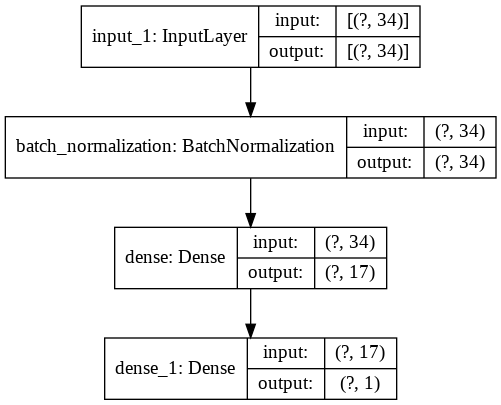

In [0]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:
# plotting the entire dataset takes FOREVER, so taking a small sample.
sample_train_df = train_df.sample(frac=0.01)

In [0]:
# pd.plotting.scatter_matrix(sample_train_df, figsize=(80, 80))

In [0]:
sns.pairplot(sample_train_df, hue='Alarm')

Error in callback <function flush_figures at 0x7ff072d7d378> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
# sample_train_df.plot(subplots=True, layout=(-1, 4), figsize=(80, 80), sharex=False)